In [1]:
import time
from ML4transients.data_access import DatasetLoader
from ML4transients.training import PytorchDataset

print("Loading dataset...")
t0 = time.time()
dataset = DatasetLoader('/sps/lsst/groups/transients/HSC/fouchez/raphael/data/UDEEP_norm')
print(f"Dataset loaded in {time.time() - t0:.2f} seconds")

2025-08-15 17:14:37.508086: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-15 17:14:37.525070: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755270877.545986  647174 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755270877.552331  647174 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755270877.569211  647174 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Loading dataset...
Dataset loaded in 0.15 seconds


Loading cutouts from visit 274


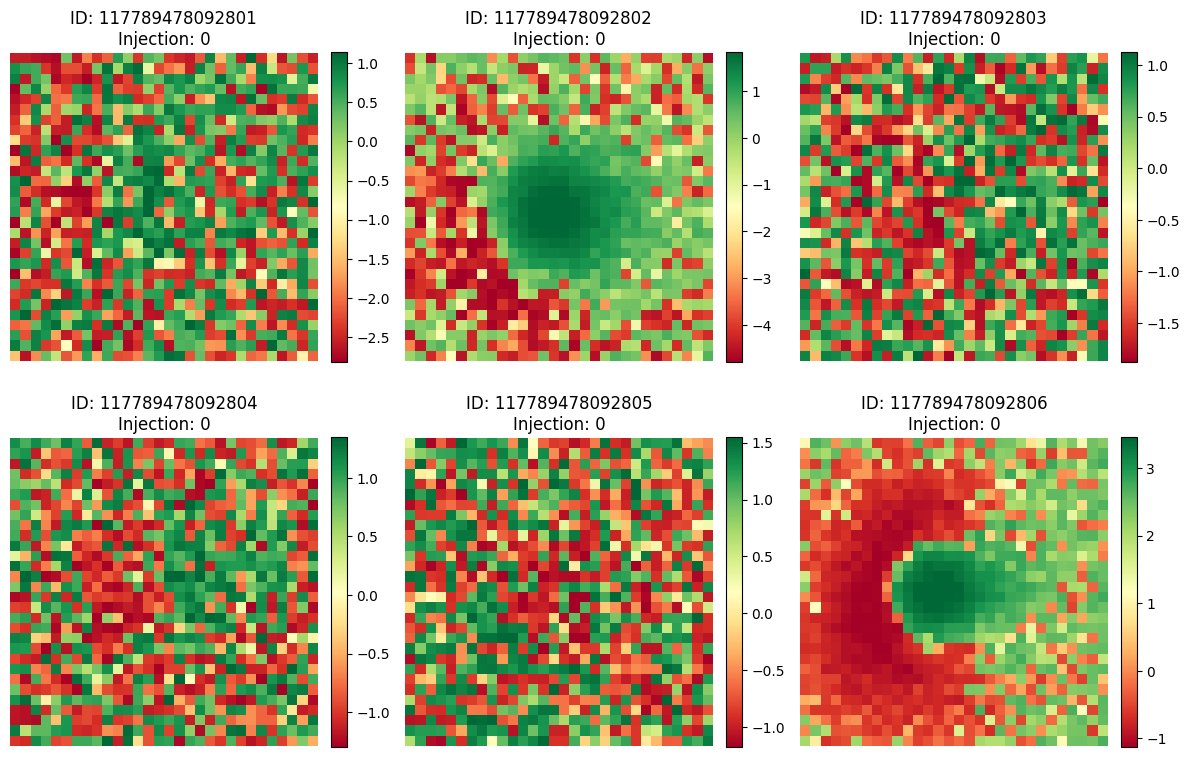

Cutout shape: (30, 30)
Value range: [-1.128, 3.455]


In [2]:
import matplotlib.pyplot as plt
import numpy as np

first_visit = dataset.visits[0]
print(f"Loading cutouts from visit {first_visit}")

cutout_loader = dataset.cutouts[first_visit]
feature_loader = dataset.features[first_visit]
sample_ids = cutout_loader.ids[:6]

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for i, dia_id in enumerate(sample_ids):
    cutout = cutout_loader.get_by_id(dia_id)
    features = feature_loader.get_by_id(dia_id)
    is_injection = features['is_injection'].iloc[0] if not features.empty else False
    
    im = axes[i].imshow(cutout, cmap='RdYlGn', origin='lower')
    axes[i].set_title(f'ID: {dia_id}\nInjection: {is_injection}')
    axes[i].axis('off')
    plt.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

print(f"Cutout shape: {cutout.shape}")
print(f"Value range: [{cutout.min():.3f}, {cutout.max():.3f}]")

In [6]:
import time
import matplotlib.pyplot as plt
import numpy as np

first_visit = dataset.visits[0]
sample_dia_source_id = dataset.cutouts[first_visit].ids[10]

print(f"Performance comparison for diaSourceId: {sample_dia_source_id}")
print("=" * 60)

# Method 1: Lightcurve only
print("\nMethod 1: Lightcurve columns only")
start_time = time.time()
data_lc_only = dataset.get_complete_lightcurve_data(sample_dia_source_id, load_cutouts=False)
time_lc_only = time.time() - start_time

if data_lc_only:
    print(f"Success: {data_lc_only['num_sources']} sources, {len(data_lc_only['lightcurve'])} LC points")
    print(f"Time: {time_lc_only:.3f}s")
else:
    print("Failed")

print("-" * 60)

# Method 2: Lightcurve + cutouts
print("\nMethod 2: Lightcurve + cutouts")
start_time = time.time()
data_full = dataset.get_complete_lightcurve_data(sample_dia_source_id, load_cutouts=True)
time_full = time.time() - start_time

if data_full:
    print(f"Success: {data_full['num_sources']} sources, {len(data_full['cutouts'])} cutouts")
    print(f"Time: {time_full:.3f}s")
else:
    print("Failed")

print("=" * 60)

# Performance summary
if data_lc_only and data_full:
    speedup = time_full / time_lc_only
    print(f"\nSpeedup: {speedup:.1f}x faster (lightcurve-only)")
    print(f"Time saved: {time_full - time_lc_only:.3f}s")

Performance comparison for diaSourceId: 117789478092811

Method 1: Lightcurve columns only
Step 1 - Get source IDs: 0.017s (169 sources found)
Step 2 - Get object ID: 0.006s (object_id: 3495980783397502987)
Step 3 - Get lightcurve data: 0.064s (169 lightcurve points)
Total lightcurve data retrieval time: 0.088s
Success: 169 sources, 169 LC points
Time: 0.088s
------------------------------------------------------------

Method 2: Lightcurve + cutouts
Step 1 - Get source IDs: 0.013s (169 sources found)
Step 2 - Get object ID: 0.006s (object_id: 3495980783397502987)
Step 3 - Get lightcurve data: 0.057s (169 lightcurve points)
Step 4a - Group by visit: (169 visits)
      Cutout batch load (1 IDs): 0.133s (open: 0.001s, ids: 0.000s, index: 0.000s, read: 0.132s, map: 0.000s)
      Cutout batch load (1 IDs): 0.172s (open: 0.001s, ids: 0.000s, index: 0.000s, read: 0.171s, map: 0.000s)
      Cutout batch load (1 IDs): 0.133s (open: 0.001s, ids: 0.000s, index: 0.000s, read: 0.132s, map: 0.000s)

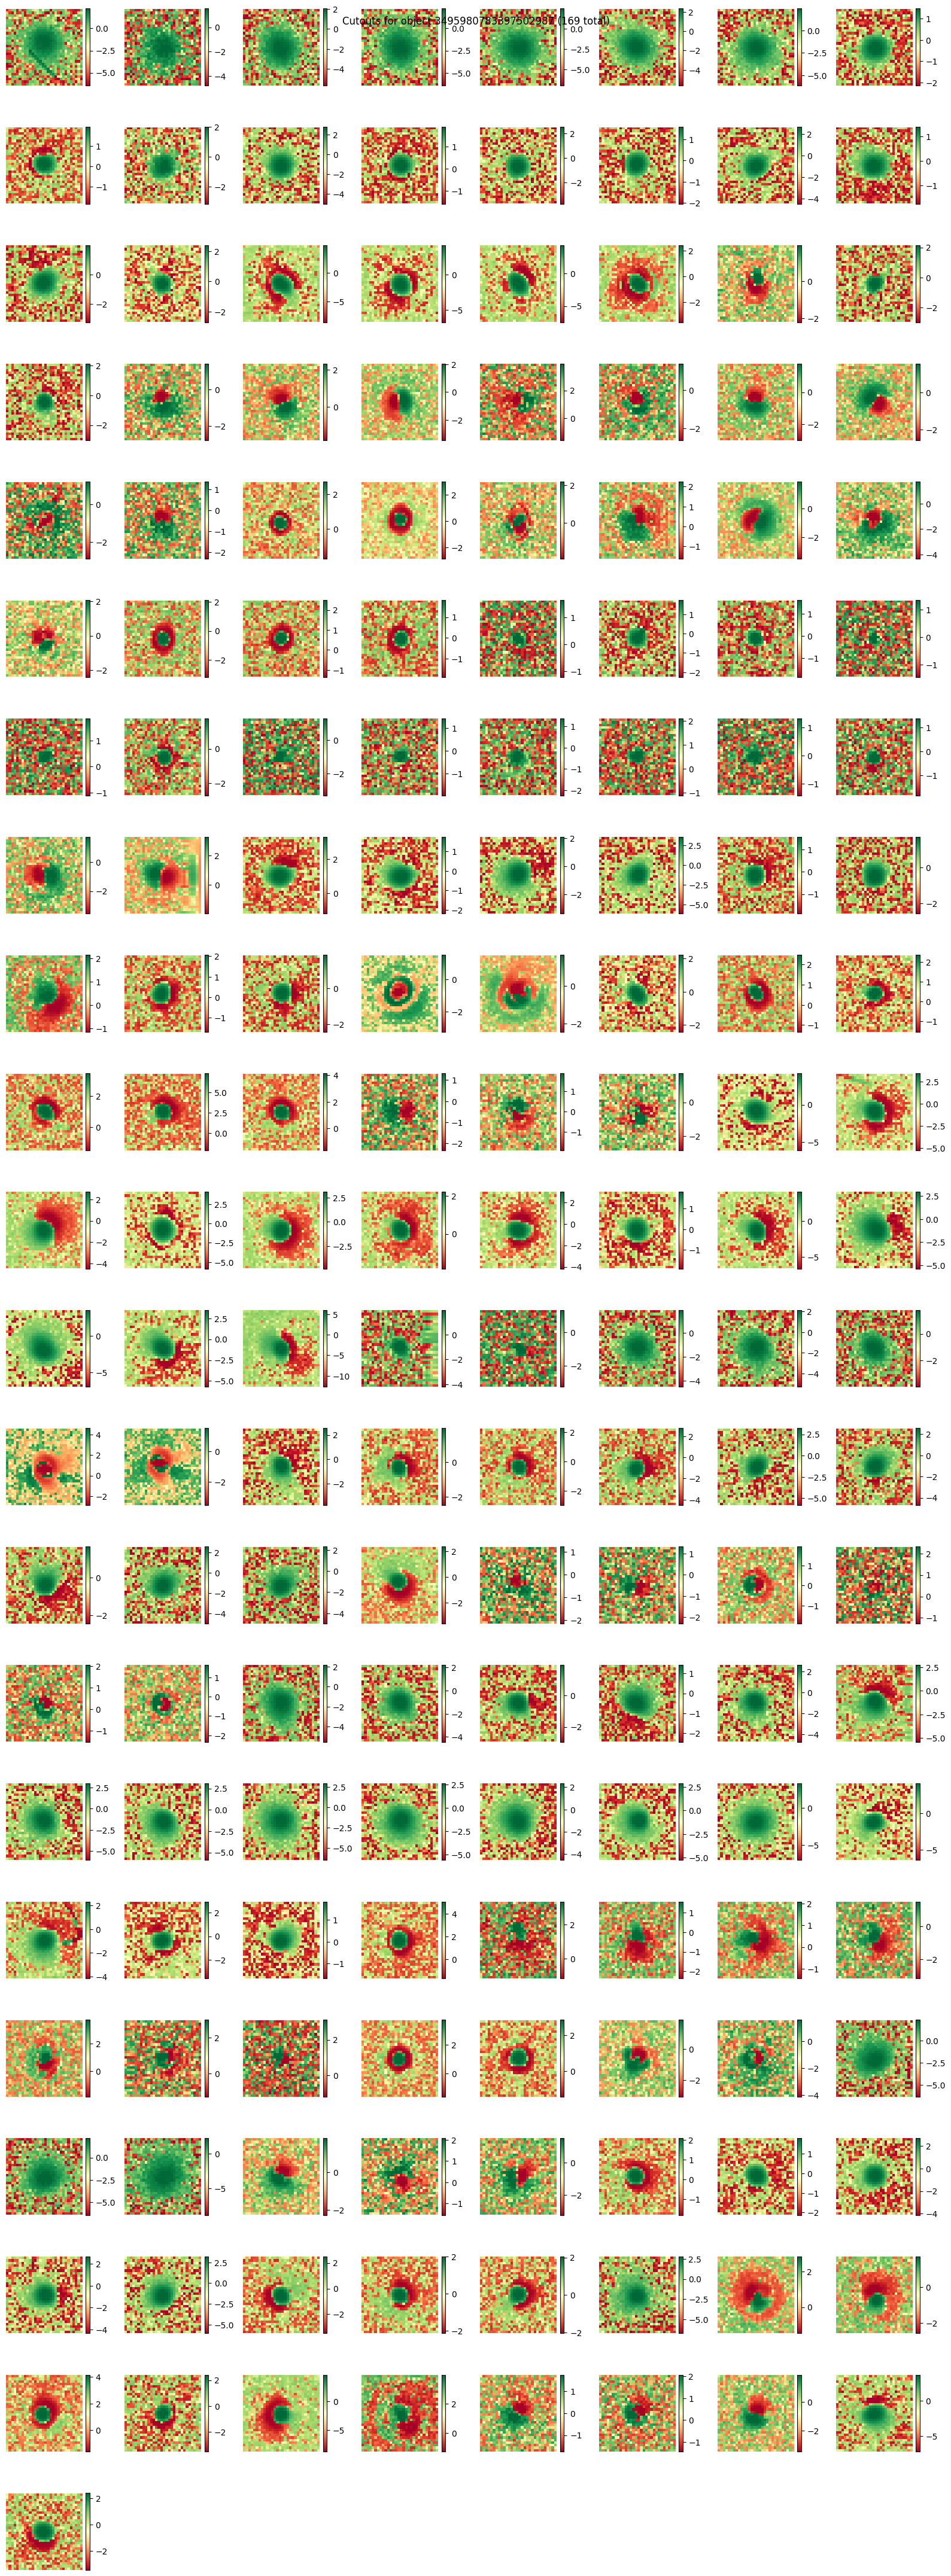

In [4]:
# Plot all cutouts
if data_full and data_full['cutouts']:
    cutouts = data_full['cutouts']
    lightcurve = data_full['lightcurve']
    
    # Sort by time if available
    if 'diaSourceId' in lightcurve.columns and 'midpointMjdTai' in lightcurve.columns:
        time_map = dict(zip(lightcurve['diaSourceId'], lightcurve['midpointMjdTai']))
        sorted_ids = sorted(cutouts.keys(), key=lambda x: time_map.get(x, 0))
    else:
        sorted_ids = list(cutouts.keys())
    
    n_cutouts = len(cutouts)
    cols = min(8, n_cutouts)
    rows = (n_cutouts + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(2*cols, 2*rows))
    if n_cutouts == 1:
        axes = [axes]
    elif rows == 1:
        axes = axes.reshape(1, -1)
    axes = axes.flatten()
    
    for i, src_id in enumerate(sorted_ids):
        im = axes[i].imshow(cutouts[src_id], cmap='RdYlGn', origin='lower')
        axes[i].axis('off')
        plt.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)
    
    for i in range(n_cutouts, len(axes)):
        axes[i].set_visible(False)
    
    plt.suptitle(f'Cutouts for object {data_full["object_id"]} ({n_cutouts} total)')
    plt.tight_layout()
    plt.show()
else:
    print("No cutouts available")

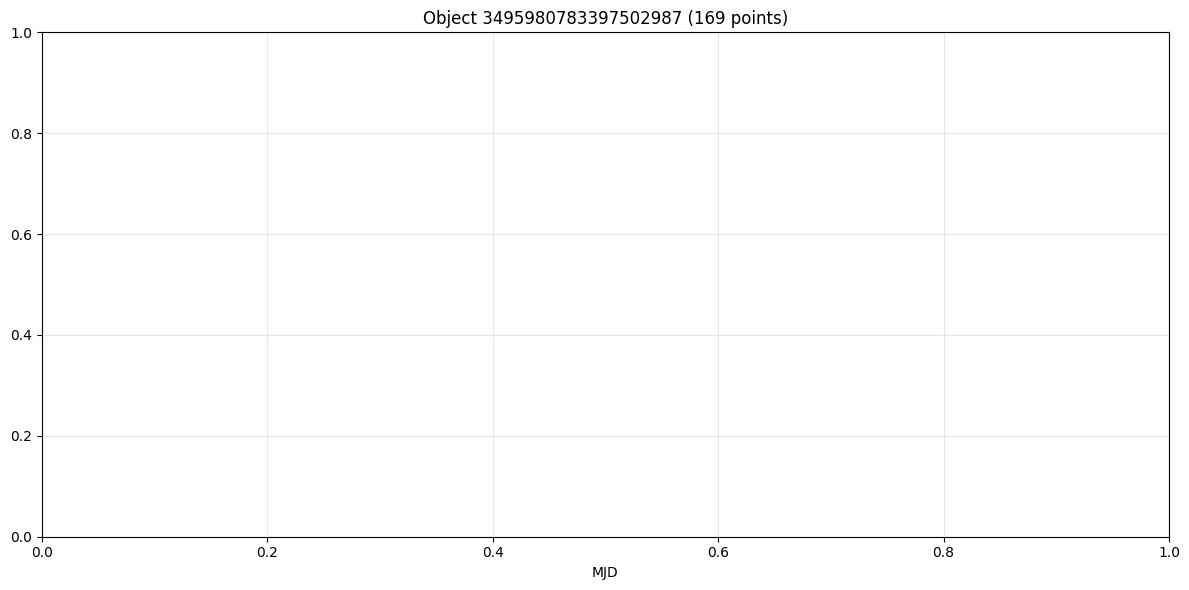

Time span: 1183.0 days
Bands: y, z, i, g, N921, r


In [5]:
# Plot lightcurve
if data_lc_only and data_lc_only['lightcurve'] is not None:
    lc = data_lc_only['lightcurve']
    
    if 'midpointMjdTai' in lc.columns:
        fig, ax = plt.subplots(1, 1, figsize=(12, 6))
        
        if 'mag' in lc.columns:
            if 'band' in lc.columns:
                bands = lc['band'].unique()
                colors = plt.cm.Set1(np.linspace(0, 1, len(bands)))
                
                for i, band in enumerate(bands):
                    band_data = lc[lc['band'] == band]
                    ax.scatter(band_data['midpointMjdTai'], band_data['mag'], 
                              label=f'Band {band}', color=colors[i], alpha=0.7, s=50)
                    
                    if 'magErr' in lc.columns:
                        ax.errorbar(band_data['midpointMjdTai'], band_data['mag'], 
                                   yerr=band_data['magErr'], fmt='none', 
                                   color=colors[i], alpha=0.5)
                ax.legend()
            else:
                ax.scatter(lc['midpointMjdTai'], lc['mag'], alpha=0.7, s=50)
                if 'magErr' in lc.columns:
                    ax.errorbar(lc['midpointMjdTai'], lc['mag'], yerr=lc['magErr'], 
                               fmt='none', alpha=0.5)
            
            ax.set_ylabel('Magnitude')
            ax.invert_yaxis()
            
        elif 'psFlux' in lc.columns:
            if 'band' in lc.columns:
                bands = lc['band'].unique()
                colors = plt.cm.Set1(np.linspace(0, 1, len(bands)))
                
                for i, band in enumerate(bands):
                    band_data = lc[lc['band'] == band]
                    ax.scatter(band_data['midpointMjdTai'], band_data['psFlux'], 
                              label=f'Band {band}', color=colors[i], alpha=0.7, s=50)
                    
                    if 'psFluxErr' in lc.columns:
                        ax.errorbar(band_data['midpointMjdTai'], band_data['psFlux'], 
                                   yerr=band_data['psFluxErr'], fmt='none', 
                                   color=colors[i], alpha=0.5)
                ax.legend()
            else:
                ax.scatter(lc['midpointMjdTai'], lc['psFlux'], alpha=0.7, s=50)
                if 'psFluxErr' in lc.columns:
                    ax.errorbar(lc['midpointMjdTai'], lc['psFlux'], yerr=lc['psFluxErr'], 
                               fmt='none', alpha=0.5)
            
            ax.set_ylabel('Flux')
        
        ax.set_xlabel('MJD')
        ax.set_title(f'Object {data_lc_only["object_id"]} ({len(lc)} points)')
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Basic stats
        time_span = lc['midpointMjdTai'].max() - lc['midpointMjdTai'].min()
        print(f"Time span: {time_span:.1f} days")
        if 'band' in lc.columns:
            print(f"Bands: {', '.join(lc['band'].unique())}")
    else:
        print("No time data available")
else:
    print("No lightcurve data available")